In [1]:
from llama_cpp import Llama
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import torch
from torch.nn import functional as F

In [10]:
def get_logits_and_probs(LLM, prompt):
    tokens = LLM.tokenize(prompt.encode('utf-8'))
    LLM.reset()
    LLM.eval(tokens)
    logits = LLM.eval_logits
    logits = np.array(logits[0])
    probs=F.softmax(torch.from_numpy(logits)).numpy()
    return logits, probs

In [3]:
def plot_logits(logits, bins=50):
    counts, bins = np.histogram(logits, bins=bins)
    plt.stairs(counts, bins)
    plt.title('Histogram of logits')

In [29]:
def plot_probs(probs, bins=10, bins_to_skip=1):
    counts, bins = np.histogram(probs, bins=bins)
    # Observing that the vast majority of tokens are in the first bin, i.e. have incredibly small probability.
    print('There are {} tokens outside the {} smallest bins.'.format(len(np.where(probs>bins[bins_to_skip])[0]), bins_to_skip))
    # Don't plot the smallest bins since they are not interesting and dwarf all other bins
    plt.stairs(counts[bins_to_skip:], bins[bins_to_skip:])
    plt.title('Histogram of Token Probabilities')

In [5]:
def plot_most_likely_tokens(LLM, probs, num_tokens_to_plot=10):
    ind = np.argpartition(probs, -num_tokens_to_plot)[-num_tokens_to_plot:]

    likely_tokens = []
    token_probs = []

    for token in ind:
        c_token = [(ctypes.c_int)(*[token])]
        print('Token: {}, Prob: {}'.format(LLM.detokenize(c_token), probs[token]))
        likely_tokens.append(LLM.detokenize(c_token))
        token_probs.append(probs[token])

    plt.bar(likely_tokens, token_probs)
    plt.title('Bar chart of 10 most likely tokens')

In [6]:
def greedy_response_search(LLM, prompt, depth=2, num_tokens=2):
    '''Take the {num_tokens} most likely tokens, then for each token, find the {num_tokens} most likely tokens. Repeat {depth} times'''
    responses = [prompt]
    response_probs = [1.0]
    for cur in range(0, depth):
        next_responses = []
        next_probs = []
        for ind, response in enumerate(responses):
            #print('evaluating:')
            #print(response)
            tokens = LLM.tokenize(response.encode('utf-8'))
            LLM.reset()
            LLM.eval(tokens)
            logits = LLM._logits()
            logits = np.array(logits[0])
            probs=F.softmax(torch.from_numpy(logits)).numpy()
            for next_token in np.argpartition(logits, -num_tokens)[-num_tokens:]:
                c_token = [(ctypes.c_int)(*[next_token])]
                # print('Token: {} Detokenized: {}'.format(token, LLM.detokenize(c_token)))
                #print('Found token: {}'.format(LLM.detokenize(c_token).decode("utf-8")))
                next_responses.append(response + LLM.detokenize(c_token).decode("utf-8"))
                next_probs.append(response_probs[ind]*probs[next_token])
        responses = next_responses
        response_probs = next_probs
    responses = [x[len(prompt):] for x in responses]
    return responses, response_probs

In [ ]:
def count_tokens_with_prob_above_threshold_during_generation(LLM, prompt, depth, threshold):
    '''Generate {depth} tokens. For each generation, count the nubmer of tokens with probability above {threshold}.'''
    responses = [prompt]
    
    for cur in range(0, depth):
        next_responses = []
        next_probs = []
        for ind, response in enumerate(responses):
            #print('evaluating:')
            #print(response)
            tokens = LLM.tokenize(response.encode('utf-8'))
            LLM.reset()
            LLM.eval(tokens)
            logits = LLM._logits()
            logits = np.array(logits[0])
            probs=F.softmax(torch.from_numpy(logits)).numpy()
            for next_token in np.argpartition(logits, -num_tokens)[-num_tokens:]:
                c_token = [(ctypes.c_int)(*[next_token])]
                # print('Token: {} Detokenized: {}'.format(token, LLM.detokenize(c_token)))
                #print('Found token: {}'.format(LLM.detokenize(c_token).decode("utf-8")))
                next_responses.append(response + LLM.detokenize(c_token).decode("utf-8"))
                next_probs.append(response_probs[ind]*probs[next_token])
        responses = next_responses
        response_probs = next_probs
    responses = [x[len(prompt):] for x in responses]
    return responses, response_probs

In [17]:
def get_mean_and_std_dev(probs):
    print('Mean: {}, Std Dev: {}'.format(np.mean(probs), np.std(probs)))

In [37]:
prompt = """Write a scifi novel about a version of earth where humans procreate using a special kind of vegetable, but there's a blight killing off the vegetable."""
#prompt = """Write a profound fantasy story about a weird little gremlin who just wants to fit in with his peers. He proves himself by defending the goblin village from a passing knight. Be creative and detailed, using vivid imagery and plenty of dialogue. Introduce characters as necessary. Don't use tropes."""

In [35]:
model_bin = "/media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/VicUnlocked-30B-LoRA.ggml.q5_0.bin"
LLM = Llama(model_path=model_bin, n_ctx=2048, n_threads=7, n_batch=512)

llama.cpp: loading model from /media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/VicUnlocked-30B-LoRA.ggml.q5_0.bin
llama_model_load_internal: format     = ggjt v2 (latest)
llama_model_load_internal: n_vocab    = 32000
llama_model_load_internal: n_ctx      = 2048
llama_model_load_internal: n_embd     = 6656
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 52
llama_model_load_internal: n_layer    = 60
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 8 (mostly Q5_0)
llama_model_load_internal: n_ff       = 17920
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 30B
llama_model_load_internal: ggml ctx size = 135.75 KB
llama_model_load_internal: mem required  = 23634.31 MB (+ 3124.00 MB per state)
llama_model_load_internal: [cublas] offloading 0 layers to GPU
llama_model_load_internal: [cublas] total VRAM used: 0 MB
llama_init_from_file: kv self size  = 3120.00 MB
AVX = 1 |

/tmp/ipykernel_719270/2381194746.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


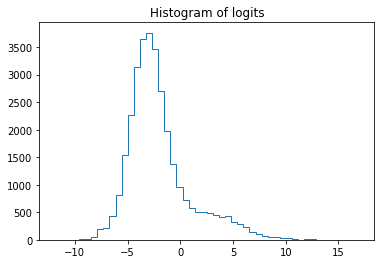

There are 7 tokens outside the 1 smallest bins.


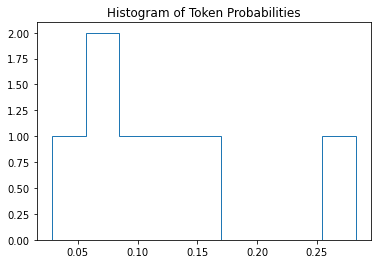

Token: b' ', Prob: 0.010554189529064152
Token: b' The', Prob: 0.1142727017210929
Token: b' Here', Prob: 0.04552169384042618
Token: b' Sure', Prob: 0.10933925496598586
Token: b' Chapter', Prob: 0.14515160783790143
Token: b' Title', Prob: 0.2828708123852987
Token: b' "', Prob: 0.0720796878367604
Token: b' As', Prob: 0.019646607016644564
Token: b' Once', Prob: 0.01311064731243568
Token: b' In', Prob: 0.0631994677992509


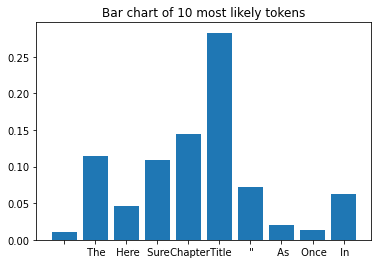

Mean: 3.125000000000006e-05, Std Dev: 0.002079641261615858


In [38]:
vicunlocked_prompt_format = """<s>A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.

USER: {prompt}
ASSISTANT:"""

logits, probs = get_logits_and_probs(LLM, vicunlocked_prompt_format.format(prompt=prompt))
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(LLM, probs)
plt.show()
get_mean_and_std_dev(probs)

In [39]:
model_bin = "/media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/wizard-mega-13b_ggml_q4_0.bin"
LLM = Llama(model_path=model_bin, n_ctx=2048, n_threads=7, n_batch=512)


llama.cpp: loading model from /media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/wizard-mega-13b_ggml_q4_0.bin
llama_model_load_internal: format     = ggjt v2 (latest)
llama_model_load_internal: n_vocab    = 32000
llama_model_load_internal: n_ctx      = 2048
llama_model_load_internal: n_embd     = 5120
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 40
llama_model_load_internal: n_layer    = 40
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 2 (mostly Q4_0)
llama_model_load_internal: n_ff       = 13824
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 13B
llama_model_load_internal: ggml ctx size =  90.75 KB
llama_model_load_internal: mem required  = 9807.48 MB (+ 1608.00 MB per state)
llama_model_load_internal: [cublas] offloading 0 layers to GPU
llama_model_load_internal: [cublas] total VRAM used: 0 MB
llama_init_from_file: kv self size  = 1600.00 MB
AVX = 1 | AVX2 

/tmp/ipykernel_719270/2381194746.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


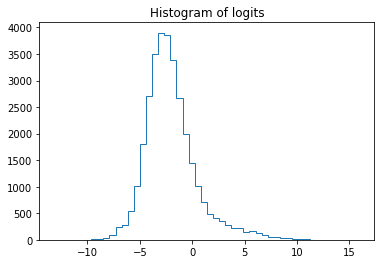

There are 6 tokens outside the 1 smallest bins.


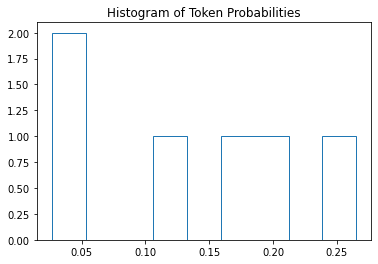

Token: b'"', Prob: 0.009450851570922866
Token: b'Pro', Prob: 0.010272273338296683
Token: b'S', Prob: 0.010896885147573962
Token: b'It', Prob: 0.012260884463681834
Token: b'As', Prob: 0.04124542727462139
Token: b'The', Prob: 0.05035930395820062
Token: b'Once', Prob: 0.11283278933574853
Token: b'Title', Prob: 0.16015727046812553
Token: b'Ch', Prob: 0.20038053601747083
Token: b'In', Prob: 0.2652110724096536


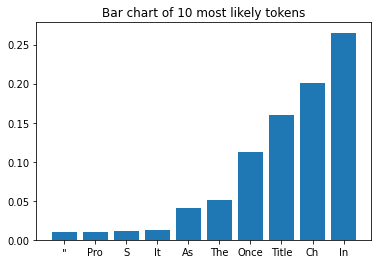

Mean: 3.1250000000000014e-05, Std Dev: 0.0021922982604191477


In [43]:
wizard_prompt_format = """{prompt}
### Response:
"""

logits, probs = get_logits_and_probs(LLM, wizard_prompt_format.format(prompt=prompt))
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(LLM, probs)
plt.show()
get_mean_and_std_dev(probs)